## Pythonによる画像解析実例 #3-1: 出芽酵母位相差像の分節化と蛍光fociの解析  
PPATプロジェクトにおける解析事例。  
出芽酵母の60倍位相差像から細胞の輪郭を特定し、輪郭内におけるAde4-GFPの蛍光fociを検出&定量。  
これまではFIJIを使用してJythonマクロで解析していたが、同等の機能をPythonで再現する。

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage import io, img_as_float, img_as_ubyte
import imageio
from PIL import Image as pilimage
from IPython.display import display, Image
from skimage.color import rgb2gray
from skimage.util import invert, img_as_ubyte, img_as_uint, img_as_bool
from cv2_rolling_ball import subtract_background_rolling_ball
from skimage.filters import threshold_isodata
from skimage.segmentation import clear_border
from skimage.morphology import binary_opening
from scipy import ndimage
from tifffile import tifffile as tiff

from skimage.filters import threshold_li
from skimage.morphology import skeletonize
from skimage import exposure
from skimage import restoration

# Jupyter notebookの中で画像を表示させるための関数、読み込んだ画像が16-bitならば画像を8bitに変換するように修正
def show(img_grey):
    if img_grey.dtype == "uint16":
        img_grey = cv2.normalize(img_grey, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    _, buf = cv2.imencode(".jpg", img_grey)
    print(type(buf))
    print(buf.shape)
    display(Image(data = buf.tobytes()))

In [2]:
img0 = tiff.imread("images/yeast_phase.tif")

In [3]:
print("読み込まれた画像の枚数:", len(img0))
print("配列の次元数:", img0.ndim)
print("配列の形状:", img0.shape)
print("要素のデータ型:", img0.dtype)

読み込まれた画像の枚数: 2
配列の次元数: 3
配列の形状: (2, 366, 366)
要素のデータ型: uint16


In [4]:
path = "images/yeast_phase.tif"
with tiff.TiffFile(path) as f: # with構文でファイルを開くと様々なメタデータが抽出できる
    print("ファイル名:",f.filename)
    print("各次元の説明:", f.series[0].axes)
    tags = f.pages[0].tags
    ijmetadata = f.imagej_metadata
lengthunit = ijmetadata["unit"]
xresolution = tags["XResolution"].value[0]/tags["XResolution"].value[1]
yresolution = tags["YResolution"].value[0]/tags["YResolution"].value[1]
print("Unit of length:", lengthunit)
print(f"Resolution in X: {xresolution} pixels per {lengthunit}")
print(f"Resolution in Y: {yresolution} pixels per {lengthunit}")
print(f"Voxel size: {1/xresolution} x {1/yresolution} x 1 {lengthunit}^3")

ファイル名: yeast_phase.tif
各次元の説明: CYX
Unit of length: micron
Resolution in X: 6.816666 pixels per micron
Resolution in Y: 6.816666 pixels per micron
Voxel size: 0.14669928085078543 x 0.14669928085078543 x 1 micron^3


<class 'numpy.ndarray'>
(27473,)


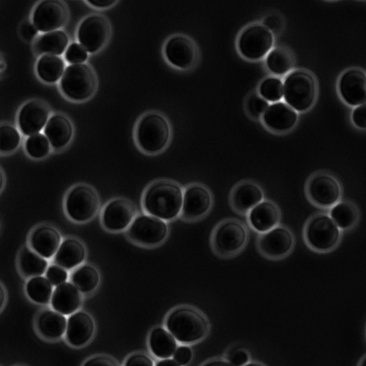

dtype('<u2')

In [5]:
# 位相差像を取り出す
img1 = img0[1,:,:]
show(img1)
img1.dtype

ImageJマクロと同じ手順で処理してみる  
1. Max intensity projection
2. Gaussian filter (radius = 1)
3. Background subtraction (radius = 25)  
4. Auto Threshold (Li)  
5. Dialation x1  
6. Skeletonize  
7. Dialate & Closing
8. Duplicate, Fill holes
9. Subtract

実際の手順:  
1. Max intensity projection
2. Gaussian filter (radius = 1)
3. Background subtraction (radius = 25)  
4. Auto Threshold (Li)  
5. Remove small object
6. Erosion x1  
7. Skeletonize  
8. Dialate & Closing
9. Duplicate, Fill holes
10. Subtract  
11. 2nd Fill holes
11. Watershed segmentation

<class 'numpy.ndarray'>
(22837,)


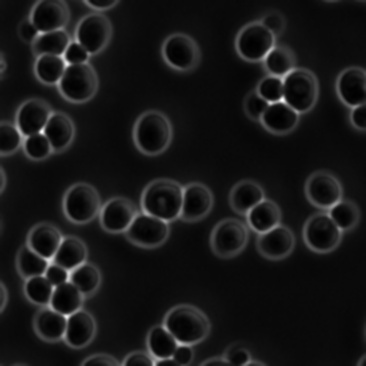

14577

In [6]:
# ガウシアンフィルタ（カーネルサイズを自動計算）
gblur = cv2.GaussianBlur(
    img1,    # 入力画像
    (0, 0), # カーネルのサイズを０にしてσの値からカーネルサイズを自動計算
    1       # X方向のσの値, Y方向のσを指定しないとXと同じ値になる
    )
show(gblur)
gblur.max()

In [7]:
# rolling background subtraction by skimage
radius = 25
background = restoration.rolling_ball(gblur, radius = radius, kernel=None,
                                     nansafe=False, num_threads=None)
filtered = gblur - background

In [8]:
# # cf. rolling background subtraction, opencv
# 8bitに直す必要がある
# gblur = img_as_ubyte(gblur) # 16bit -> 8bit
# radius = 25
# # gblur = gblur.astype(np.uint8)
# im, background = subtract_background_rolling_ball(gblur, radius, light_background=False,
#                                      use_paraboloid=False, do_presmooth=False)
# gblur = img_as_uint(gblur) # 8bit -> 16bit

<class 'numpy.ndarray'>
(23509,)


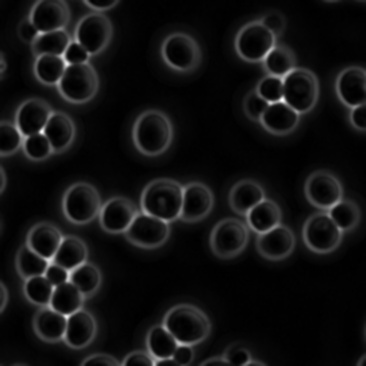

In [9]:
show(filtered)

In [10]:
# from skimage.filters import try_all_threshold
# fig, ax = try_all_threshold(gblur, figsize =(7, 7), verbose = False)
# plt.show()

In [11]:
# Auto threshold, Li method
from skimage.filters import threshold_li
thresh = threshold_li(filtered)
mask = np.where(filtered > thresh, 1, 0) # numpyによる2値化処理

<class 'numpy.ndarray'>
(53989,)


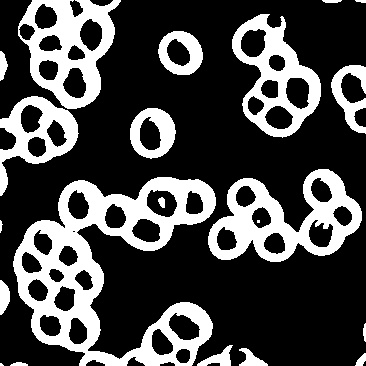

In [12]:
show(mask*255)

<class 'numpy.ndarray'>
(52244,)


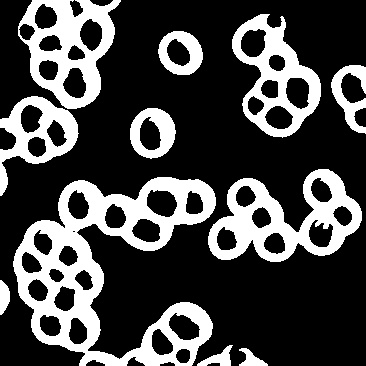

In [13]:
# 小さなブロブを除く
from skimage import io, morphology
arr = mask > 0
cleaned = morphology.remove_small_objects(arr, min_size=256)
cleaned = img_as_ubyte(cleaned)
show(cleaned)

<class 'numpy.ndarray'>
(50430,)


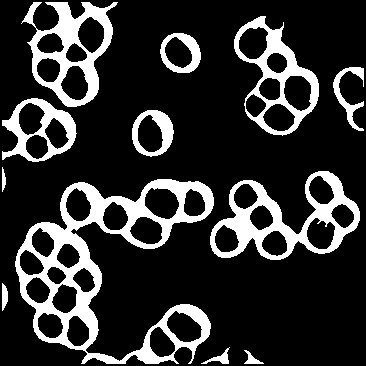

In [14]:
# dilationではなくerosionにする
from scipy import ndimage
erosion = ndimage.binary_erosion(cleaned, iterations= 2).astype(mask.dtype)
show(erosion*255)

<class 'numpy.ndarray'>
(34602,)


/Applications/anaconda3/lib/python3.9/site-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


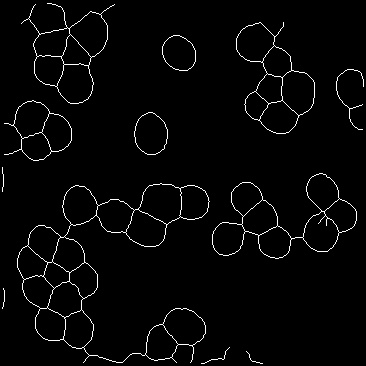

In [15]:
# skeletonize
from skimage.morphology import skeletonize
sk = skeletonize(erosion, method='lee')
show(sk*255)

In [16]:
# Dialate & closing
sk_dia = ndimage.binary_dilation(sk, iterations= 1).astype(sk.dtype)
sk_close = ndimage.binary_closing(sk_dia, iterations=1).astype(sk_dia.dtype)

<class 'numpy.ndarray'>
(42109,)


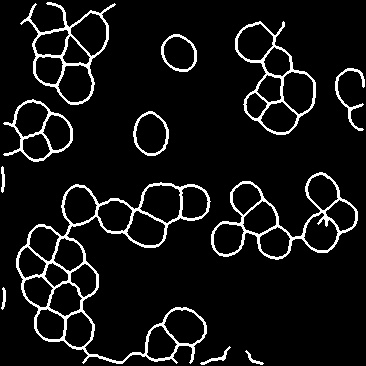

In [17]:
show(sk_close*255)

<class 'numpy.ndarray'>
(29077,)


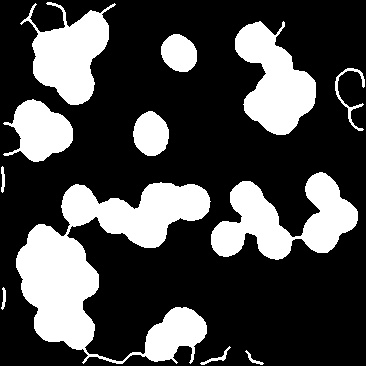

In [18]:
from scipy import ndimage
filled = ndimage.binary_fill_holes(sk_close).astype("uint8")
show(filled*255)

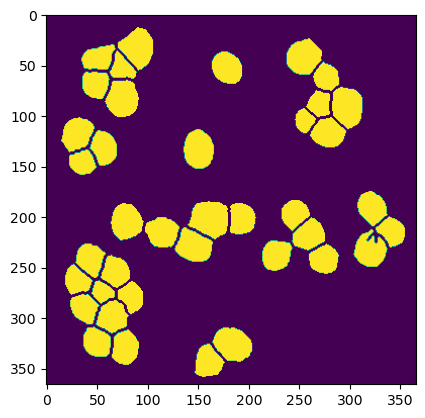

In [19]:
diff = filled - sk_close
plt.imshow(diff)

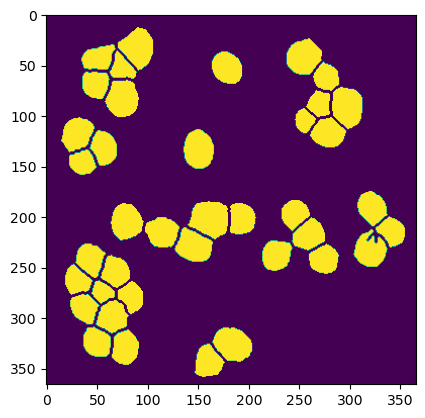

In [20]:
filled2= ndimage.binary_fill_holes(diff).astype("uint8")
plt.imshow(filled2)

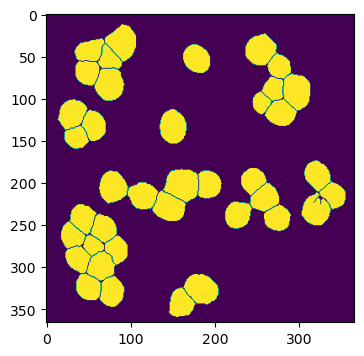

In [21]:
# 確実に背景である領域を求める
# 対象（白）の領域を膨張させるということは、残った黒の背景は「確実に背景」
sure_bg = ndimage.binary_dilation(filled2, iterations= 1).astype(filled2.dtype)
plt.figure(figsize=(4,4))
plt.imshow(sure_bg)

距離変換で得られた値の最小値と最大値: 0.0 16.778297
閾値（距離変換で得られた値の最大値×0.1）: 0.0
float32


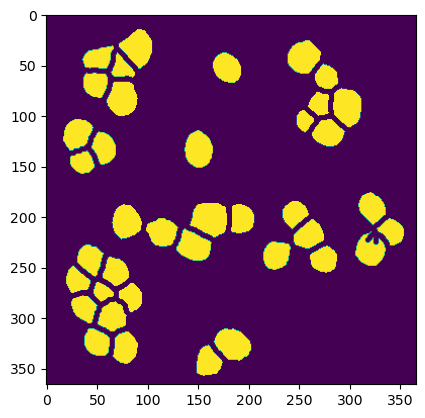

In [22]:
dist_transform = cv2.distanceTransform(filled2, cv2.DIST_L2, 5)
ratio = 0.1
print("距離変換で得られた値の最小値と最大値:", dist_transform.min(), dist_transform.max())
print(f'閾値（距離変換で得られた値の最大値×{ratio}）:',ratio*dist_transform.min())
ret, sure_fg = cv2.threshold(dist_transform, ratio*dist_transform.max(),255,0)
plt.imshow(sure_fg)
print(sure_fg.dtype)

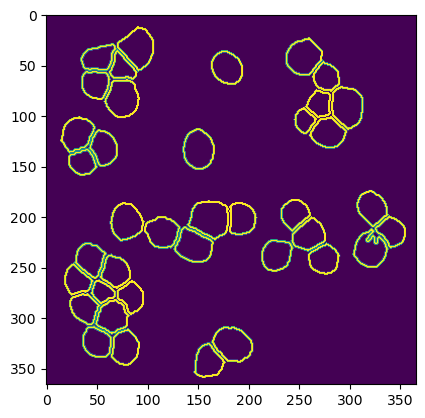

In [23]:
# Finding unknown region
# 背景でも前景でもないunknownな領域の情報」を取得
# 「絶対に背景」から「絶対に前景」の情報を引く
sure_fg = np.uint8(sure_fg)
sure_bg = np.uint8(sure_bg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown*255)

In [24]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown == 1] = 0 # boolean indexing
# この時点での背景のピクセル値 -> 1、各オブジェクトのピクセル値 -> 2,3,...,38, unknownのピクセル値 -> 0

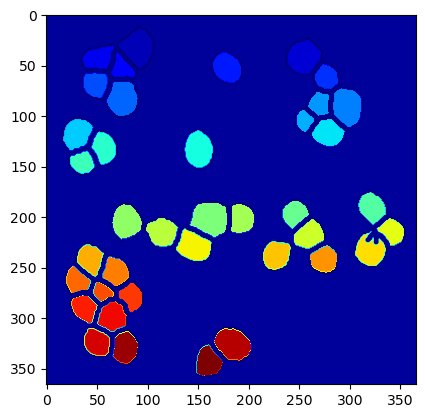

In [25]:
plt.imshow(markers, cmap = "jet")

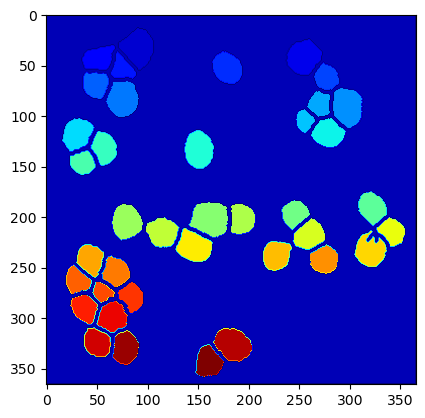

In [26]:
# Watershed関数による処理
path = "images/yeast_phase.tif"
img_rgb = cv2.imread(path, 1)
markers = cv2.watershed(img_rgb, markers) # imgはRGBである必要がある
# この時点での背景のピクセル値 -> 1、境界領域 -> -1, 各オブジェクト -> 2,3,...,38,
plt.imshow(markers, cmap = "jet")

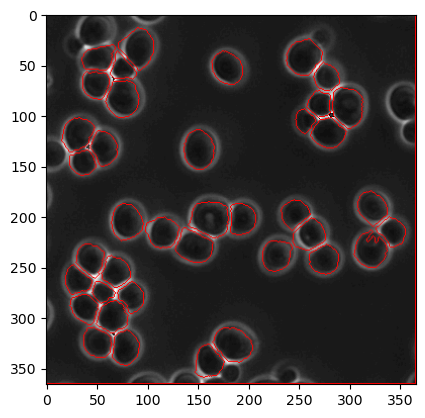

In [27]:
# 境界領域を赤色にする
img1_1 = img_as_ubyte(img1)*5
img_rgb_segm = cv2.cvtColor(img1_1, cv2.COLOR_GRAY2RGB)
img_rgb_segm[markers == -1] = (255, 0, 0)
plt.imshow(img_rgb_segm)

In [6]:
from skimage.filters import threshold_li
from skimage import io, morphology
from scipy import ndimage
from skimage.morphology import skeletonize
from skimage import exposure
from skimage import restoration

In [7]:
# 関数化
def segm_phimg(path, radius = 25, ratio = 0.1):

    img0 = tiff.imread(path)
    img1 = img0[1,:,:]
    gblur = cv2.GaussianBlur(
        img1,    # 入力画像
        (0, 0), # カーネルのサイズを０にしてσの値からカーネルサイズを自動計算
        1       # X方向のσの値, Y方向のσを指定しないとXと同じ値になる
        )
    background = restoration.rolling_ball(gblur, radius = radius, kernel=None,
                                     nansafe=False, num_threads=None)
    filtered = gblur - background
    
    thresh = threshold_li(filtered)
    mask = np.where(filtered > thresh, 1, 0) # numpyによる2値化処理

    arr = mask > 0
    cleaned = morphology.remove_small_objects(arr, min_size=256)
    cleaned = img_as_ubyte(cleaned)

    erosion = ndimage.binary_erosion(cleaned, iterations= 2).astype(cleaned.dtype)

    sk = skeletonize(erosion, method='lee')
    sk_dil = ndimage.binary_dilation(sk, iterations= 1).astype(sk.dtype)
    sk_close = ndimage.binary_closing(sk_dil, iterations=1).astype(sk_dil.dtype)

    filled = ndimage.binary_fill_holes(sk_close).astype("uint8")
    diff = filled - sk_close
    filled2= ndimage.binary_fill_holes(diff).astype("uint8")
    sure_bg = ndimage.binary_dilation(filled2, iterations= 1).astype(filled2.dtype)

    dist_transform = cv2.distanceTransform(filled2, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, ratio*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    sure_bg = np.uint8(sure_bg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    # ret, markers = cv2.connectedComponents(sure_fg)
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(sure_fg)
    markers = markers+1
    markers[unknown == 1] = 0 # boolean indexing

    img_rgb = cv2.imread(path, 1)
    markers = cv2.watershed(img_rgb, markers) # imgはRGBである必要がある
    return markers, stats, centroids

In [45]:
# 参考： OpenCVのrolling ball background subtractionを使う場合、処理が10倍くらい遅い
def segm_phimg2(path, radius = 25, ratio = 0.1):

    img0 = tiff.imread(path)
    img1 = img0[1,:,:]
    gblur = cv2.GaussianBlur(
        img1,    # 入力画像
        (0, 0), # カーネルのサイズを０にしてσの値からカーネルサイズを自動計算
        1       # X方向のσの値, Y方向のσを指定しないとXと同じ値になる
        )
    gblur = img_as_ubyte(gblur) # 16bit -> 8bit
    im, background = subtract_background_rolling_ball(gblur, radius, light_background=False,
                                         use_paraboloid=False, do_presmooth=False)
    gblur = img_as_uint(gblur) # 8bit -> 16bit

    thresh = threshold_li(gblur)
    mask = np.where(gblur > thresh, 1, 0) # numpyによる2値化処理

    arr = mask > 0
    cleaned = morphology.remove_small_objects(arr, min_size=256)
    cleaned = img_as_ubyte(cleaned)

    erosion = ndimage.binary_erosion(cleaned, iterations= 2).astype(cleaned.dtype)

    sk = skeletonize(erosion, method='lee')
    sk_dil = ndimage.binary_dilation(sk, iterations= 1).astype(sk.dtype)
    sk_close = ndimage.binary_closing(sk_dil, iterations=1).astype(sk_dia.dtype)

    filled = ndimage.binary_fill_holes(sk_close).astype("uint8")
    diff = filled - sk_close
    filled2= ndimage.binary_fill_holes(diff).astype("uint8")
    sure_bg = ndimage.binary_dilation(filled2, iterations= 1).astype(filled2.dtype)

    dist_transform = cv2.distanceTransform(filled2, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, ratio*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    sure_bg = np.uint8(sure_bg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown == 1] = 0 # boolean indexing

    img_rgb = cv2.imread(path, 1)
    markers = cv2.watershed(img_rgb, markers) # imgはRGBである必要がある
    return markers

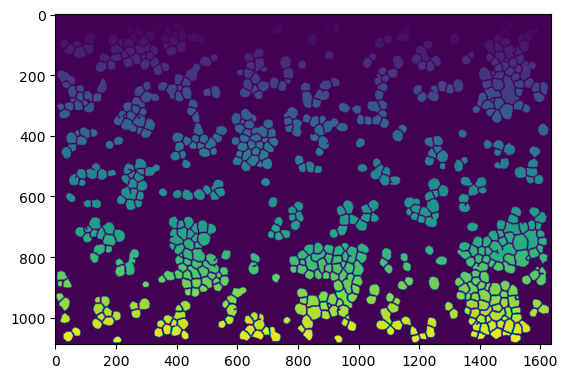

In [8]:
# %%timeit -r 1 -n 1
# 確認 -> 1.05 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
# path = "images/yeast_phase.tif"
path = "/Users/masak_takaine/210625_ade4GFP/MAX_wt_dmso_019.tif"
# path = "/Users/masak_takaine/210625_ade4GFP/MAX_wt_dmso_019_small.tif"
radius = 25
ratio = 0.1

markers, stats, centroids = segm_phimg(path, radius, ratio)
plt.imshow(markers)

True

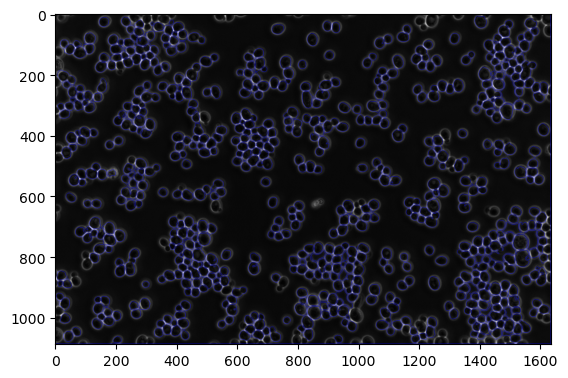

In [9]:
 # 境界領域を赤色にする
path = "/Users/masak_takaine/210625_ade4GFP/MAX_wt_dmso_019.tif"
# path = "/Users/masak_takaine/210625_ade4GFP/MAX_wt_dmso_019_small.tif"
img0 = tiff.imread(path)
img1 = img0[1,:,:]
img1 = exposure.rescale_intensity(img1)  # 明るさを調整
img1_1 = img_as_ubyte(img1)
img_rgb_segm = cv2.cvtColor(img1_1, cv2.COLOR_GRAY2RGB)
img_rgb_segm[markers == -1] = (0, 0, 255)
plt.imshow(img_rgb_segm)
cv2.imwrite("images/segmented_yeasts_phase.tif", img_rgb_segm)

In [10]:
stats[3]

array([147,  12,  29,  28, 657], dtype=int32)

True

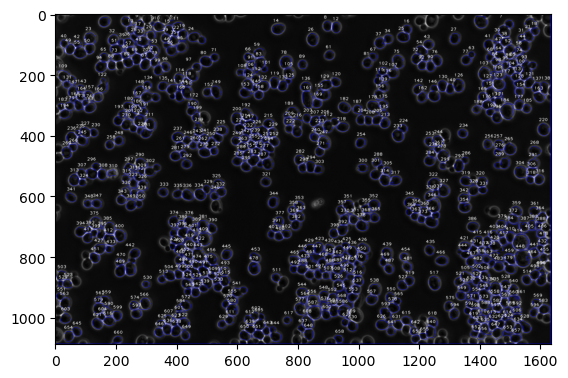

In [11]:
# statsには各ラベルごとの領域の情報が格納されている。[領域の左上のx座標, 領域の左上のy座標, 領域の幅, 領域の高さ, 面積]、stats[0]は背景の情報
# statsを利用して各領域をナンバリングした画像を作る
numbering = img_rgb_segm.copy()
for i in range(1, len(stats)):
    x, y, width, height, area = stats[i]  # このAreaは何を表している？
    cv2.putText(numbering, f"{i}", (x, y-10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1, cv2.LINE_AA)
plt.imshow(numbering)
cv2.imwrite("images/segm_num_yeasts_phase.tif", numbering)

#### 各細胞における極大点の検出  
作成したmarkersを使用して各細胞（ラベリングされた各領域）について解析  
緑蛍光画像に対して`regionprops_table()`関数を使う  
細胞の形についてはあまりあてにはならない情報

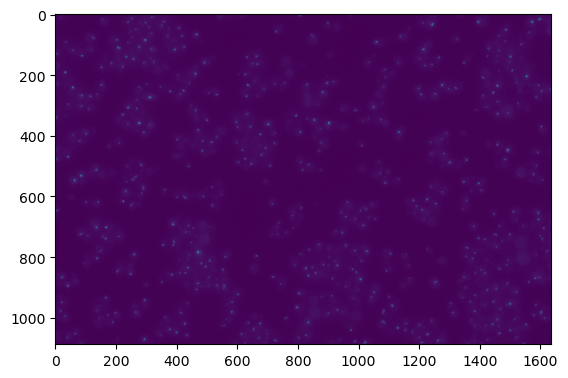

In [12]:
path = "/Users/masak_takaine/210625_ade4GFP/MAX_wt_dmso_019.tif"
# path = "/Users/masak_takaine/210625_ade4GFP/MAX_wt_dmso_019_small.tif"
img0 = tiff.imread(path)
img2 = img0[0,:,:]
plt.imshow(img2)

image_intensityを指定して、各regionの画像そのものを格納する
0行目はバックグラウンドのデータ

In [45]:
from skimage import data, util
from skimage.measure import label, regionprops_table
# img_properties = ["label", "area", "axis_major_length", "axis_minor_length","perimeter", "solidity", "feret_diameter_max","image_intensity"]
img_properties = ["label", "area","image_intensity"]
# img_properties = ["label", "area"]
prop_dic = regionprops_table(markers, intensity_image=img2, properties=img_properties)
# prop_dic = regionprops_table(markers, properties=img_properties)
df = pd.DataFrame(prop_dic)
# df["Circularity"] = (4*np.pi * df.area)/(df.perimeter)**2
# df["aspect_ratio"] = df.axis_major_length/df.axis_minor_length
# df["Roundness"] = 1/df.aspect_ratio
df = df.rename(columns = {"label": "cell_label"})
df = df.rename(columns = {"area": "cell_area"})
df = df.drop([0]) # バックグラウンドのデータを削除
df = df.reset_index(drop=True)
df["cell_label"] = df["cell_label"] - 1 # 画像のラベル番号と合わせるため

In [46]:
df.head()

,cell_label,cell_area,image_intensity
0,1,1141,"[[0, 0, 0, 0, 0, 0, 0, 603, 629, 620, 598, 0, ..."
1,2,662,"[[0, 0, 0, 0, 0, 0, 0, 0, 588, 589, 556, 605, ..."
2,3,747,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 784, 807, 8..."
3,4,908,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,5,478,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


<class 'numpy.ndarray'>
(1489,)


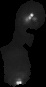

In [47]:
# 特定の画像の抽出、明らかに大きな画像の例
show(df.iloc[441, 2])

In [48]:
df.iloc[441,:]

cell_label                                                       442
cell_area                                                       2030
image_intensity    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: 441, dtype: object

In [49]:
df["cell_area"].describe()

count     660.000000
mean      659.984848
std       318.427023
min        37.000000
25%       463.750000
50%       630.500000
75%       784.000000
max      3125.000000
Name: cell_area, dtype: float64

In [50]:
df["cell_area"].median()

630.5

(array([ 0.,  6.,  4.,  2.,  3.,  7., 10.,  4.,  6., 15., 19., 22., 25.,
        26., 17., 32., 33., 31., 30., 33., 38., 24., 39., 25., 40., 26.,
        14.,  9., 10., 17.,  8.,  7., 10.,  6.,  8., 13.,  7.,  2.,  2.,
         2.,  5.,  5.,  2.,  1.,  3.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,
         0.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([   0.  ,   31.25,   62.5 ,   93.75,  125.  ,  156.25,  187.5 ,
         218.75,  250.  ,  281.25,  312.5 ,  343.75,  375.  ,  406.25,
         437.5 ,  468.75,  500.  ,  531.25,  562.5 ,  593.75,  625.  ,
         656.25,  687.5 ,  718.75,  750.  ,  781.25,  812.5 ,  843.75,
         875.  ,  906.25,  937.5 ,  968.75, 1000.  , 1031.25, 1062.5 ,
        1093.75, 1125.  , 1156.25, 1187.5 , 1218.75, 1250.  , 1281.25,
        

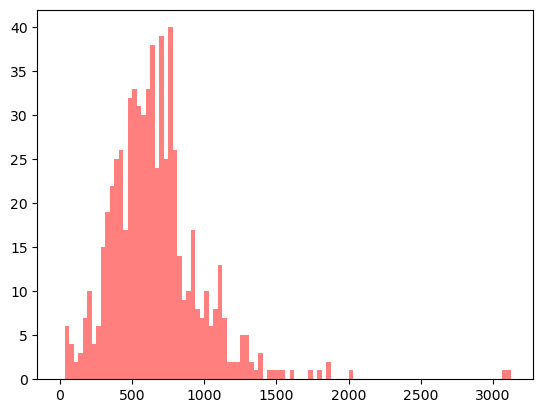

In [51]:
plt.hist(df["cell_area"].ravel(), bins = 100, range = [0, df["cell_area"].max()], color=(1,0,0), alpha = 0.5) # ravel()で1次元配列に戻す

In [52]:
show(df.iloc[361, 2])

<class 'numpy.ndarray'>
(735,)


#### cell_areaの閾値として平均±3SDを考える  
cell_areaがこの範囲に入っているラベルだけを解析対象として、範囲外のラベルは除外する  
しかし平均 - 3SDだとマイナスになってしまうので、下限は平均の1/3とする

In [53]:
cell_area_mean = df["cell_area"].mean()
cell_area_sdv = df["cell_area"].std()
min_th = cell_area_mean/3
max_th = cell_area_mean + 3*cell_area_sdv
# 条件に合致する行を抽出
labels_extracted = df[(df["cell_area"] < max_th) & (min_th < df["cell_area"])]["cell_label"]
df = df[(df["cell_area"] < max_th) & (min_th < df["cell_area"])]

#### Numbered imageを作り直す  
抽出したcellにのみ番号を振る

True

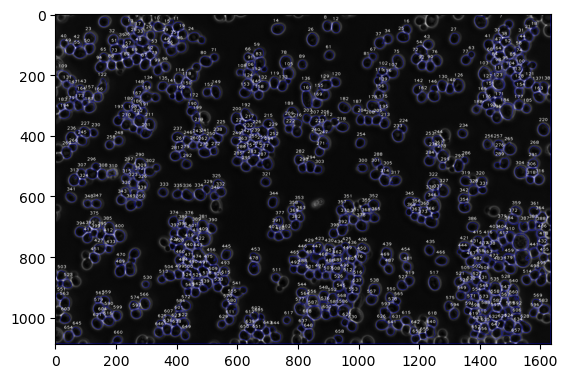

In [54]:
numbering2 = img_rgb_segm.copy()
for i in range(1, len(stats)):
    if i in np.asarray(labels_extracted):
        x, y, width, height, area = stats[i]  # このAreaは何を表している？
        cv2.putText(numbering2, f"{i}", (x, y-10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1, cv2.LINE_AA)
plt.imshow(numbering2)
cv2.imwrite("images/segm_num_yeasts_phase2.tif", numbering2)

In [55]:
from skimage.measure import label
# from skimage import data
from skimage import color
from skimage.morphology import extrema
from skimage import exposure

(array([302.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          4.,  10.,  31.,  45.,  36.,  24.,  53.,  35.,  52.,  41.,  39.,
         33.,  22.,  16.,   5.,   7.,   4.,   1.,   2.,   2.,   0.,   0.,
          2.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          2.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          3.]),
 array([   0.  ,   21.77,   43.54,   65.31,   87.08,  108.85,  130.62,
         152.39,  174.16,  195.93,  217.7 ,  239.47,  261.24,  283.01,
         304.78,  326.55,  348.32,  370.09,  391.86,  413.63,  435.4 ,
         457.17,  478.94,  500.71,  522.48,  544.25,  566.02,  587.79,
         609.56,  631.33,  653.1 ,

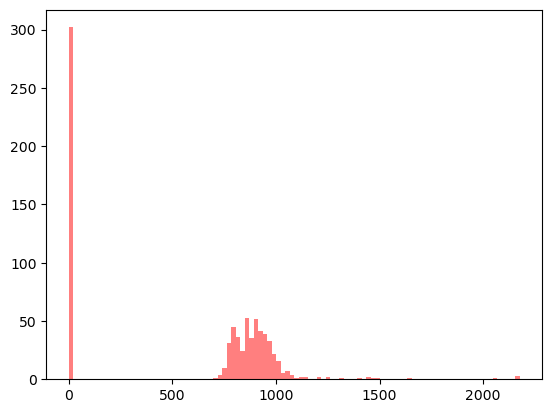

In [56]:
area5=df.loc[4, "image_intensity"]
plt.hist(area5.ravel(), bins = 100, range = [0, area5.max()], color=(1,0,0), alpha = 0.5) # ravel()で1次元配列に戻す

検出した極大点の領域は1ピクセルだけであり、細胞内のfociやgranuleよりは小さい  
fociの輝度を測定するためにdilationで領域を大きくする  
ImageJ/FIJIのマクロでは直径2ピクセルの円  
Scipyのndimage.binary_dilation()とScikit-imageのmorphology.binary_dilation()があり、  
前者はiterationを設定、後者はfootprintを設定するので注意

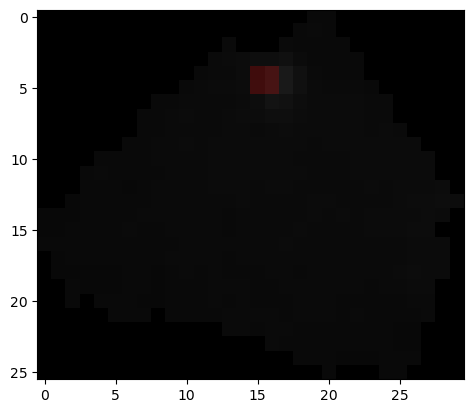

In [420]:
h = 2000
h_maxima = extrema.h_maxima(area5, h, footprint=None)

# morphology.diskで丸のfootprintを作成
disk = morphology.disk(radius = 2)
square = morphology.square(2)
h_maxima_dil= morphology.binary_dilation(h_maxima, footprint=square)
# h_maxima_dil= ndimage.binary_dilation(h_maxima, iterations= 2).astype(h_maxima.dtype)

label_h_maxima = label(h_maxima_dil)
overlay_h = color.label2rgb(label_h_maxima, area5*3, alpha=0.2, bg_label=0,
                          bg_color=None, colors=[(1, 0, 0)])
plt.imshow(overlay_h)

極大点のラベルを使って、fociのピクセル値を測定

In [421]:
prop_dic_foci = regionprops_table(label_h_maxima, intensity_image=area5, properties=["label", "area", "intensity_max", "intensity_mean"])
df_foci = pd.DataFrame(prop_dic_foci)

In [422]:
df_foci

,label,area,intensity_max,intensity_mean
0,1,4,2177.0,1757.5


個別の画像を取り出して、極大点を検出しなくても、dfのimage_intensityにmap()を使って直接h_maximaを適用できる  
h_maximaにおけるピクセル値の合計は極大点の数に等しい  
極大点の数でfoci有り無しのフラグを表す変数with_fociを追加

In [57]:
h = 2000
df["h_maxima"] = df["image_intensity"].map(lambda x: extrema.h_maxima(x, h, footprint=None))
df["num_maxima"] = df["h_maxima"].map(lambda x: x.sum()) # mapを使わないとエラー
df["with_foci"] = df["num_maxima"].map(lambda x: 0 if x == 0 else 1)
# さらに極大点のdilation、ラベリングまでdataframe内で行う
# df["h_maxima_dil"]= df["h_maxima"].map(lambda x: ndimage.binary_dilation(x, iterations= 1).astype(x.dtype))
df["h_maxima_dil"]= df["h_maxima"].map(lambda x: morphology.binary_dilation(x, footprint = morphology.square(2)).astype(x.dtype))
df["label_h_maxima"] = df["h_maxima_dil"].map(label)

In [58]:
df.head()

,cell_label,cell_area,image_intensity,h_maxima,num_maxima,with_foci,h_maxima_dil,label_h_maxima
0,1,1141,"[[0, 0, 0, 0, 0, 0, 0, 603, 629, 620, 598, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,2,662,"[[0, 0, 0, 0, 0, 0, 0, 0, 588, 589, 556, 605, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,747,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 784, 807, 8...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,4,908,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,5,478,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [59]:
res = df.groupby("with_foci").size()

In [60]:
df.groupby("num_maxima").size()

num_maxima
0    181
1    434
2      5
dtype: int64

In [30]:
res[1:].sum()/res.sum()*100

70.80645161290322

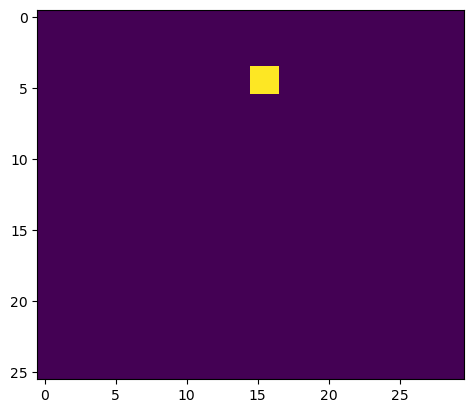

In [31]:
plt.imshow(df.iloc[4, 7])

overlay画像を作るにはdf内の元画像image_intensityとlabel_h_maximaの2つが必要  
map()関数では不可能なので、データフレームを対象とするapply()関数を使う

In [32]:
def make_overlay(df):
    return color.label2rgb(df["label_h_maxima"], df["image_intensity"]*3, alpha=0.2, bg_label=0,
                          bg_color=None, colors=[(1, 0, 0)])
    
df["overlay_h"] = df.apply(make_overlay, axis=1)

In [33]:
df.head()

,cell_label,cell_area,image_intensity,h_maxima,num_maxima,with_foci,h_maxima_dil,label_h_maxima,overlay_h
0,1,1141,"[[0, 0, 0, 0, 0, 0, 0, 603, 629, 620, 598, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,2,662,"[[0, 0, 0, 0, 0, 0, 0, 0, 588, 589, 556, 605, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,3,747,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 784, 807, 8...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,4,908,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,5,478,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


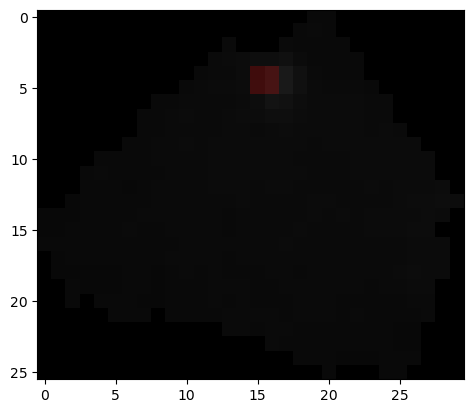

In [34]:
plt.imshow(df.iloc[4, 8])

個別のmaximaの解析  
極大点のラベル label_h_maximaと元画像image_intensityをregionprops_table()に入力し、測定結果をデータフレーム化、変数foci_dfに格納  
cell_label, cell_area, with_fociの列も作成  

極大点が無い場合はdicが返ってこないので、何も格納されない  
その場合はNaNが入ったdicを返すようにする
 

In [63]:
df["with_foci"] == 1

0       True
1       True
2       True
3       True
4       True
       ...  
655    False
656     True
657     True
658     True
659    False
Name: with_foci, Length: 620, dtype: bool

In [61]:
# def analyze_maxima(df):
#     if df["with_foci"] == 1:
#         dic = regionprops_table(df["label_h_maxima"], intensity_image = df["image_intensity"], properties=["label", "area", "intensity_max", "intensity_mean"])
#     foci_df = pd.DataFrame(dic)
#     foci_df["cell_label"] = df.cell_label
#     foci_df["cell_area"] = df.cell_area
#     foci_df["with_foci"] = df.with_foci
#     return foci_df

In [68]:
def analyze_maxima(df):
    if df["with_foci"] == 1:
        dic = regionprops_table(df["label_h_maxima"], intensity_image = df["image_intensity"], properties=["label", "area", "intensity_max", "intensity_mean"])
        foci_df = pd.DataFrame(dic)
    else:
        dic = {"label":np.nan, "area":np.nan, "intensity_max":np.nan, "intensity_mean":np.nan}
        foci_df = pd.DataFrame(dic, index=[0])# indexを何か指定しないとエラー
    foci_df["cell_label"] = df.cell_label
    foci_df["cell_area"] = df.cell_area
    foci_df["with_foci"] = df.with_foci
    
    return foci_df

In [69]:
df["foci_df"] = df.apply(analyze_maxima, axis=1)

In [70]:
df.head()

,cell_label,cell_area,image_intensity,h_maxima,num_maxima,with_foci,h_maxima_dil,label_h_maxima,foci_df
0,1,1141,"[[0, 0, 0, 0, 0, 0, 0, 603, 629, 620, 598, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",label area intensity_max intensity_mean ...
1,2,662,"[[0, 0, 0, 0, 0, 0, 0, 0, 588, 589, 556, 605, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",label area intensity_max intensity_mean ...
2,3,747,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 784, 807, 8...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",label area intensity_max intensity_mean ...
3,4,908,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",label area intensity_max intensity_mean ...
4,5,478,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",label area intensity_max intensity_mean ...


In [72]:
fdf4 = df.iloc[4, 8]
fdf4

,label,area,intensity_max,intensity_mean,cell_label,cell_area,with_foci
0,1,4,2177.0,1757.5,5,478,1


pd.concat()で全てのfoci_dfを一つにまとめる  
labelをfoci_labelにrenameして、変数も並べ替え

In [75]:
foci_df = pd.concat(list(df["foci_df"]))
foci_df = foci_df.rename(columns = {"label": "foci_label"})
foci_df = foci_df.iloc[:, [4,5,6,0,1,2,3]]

In [76]:
foci_df.head(30)

,cell_label,cell_area,with_foci,foci_label,area,intensity_max,intensity_mean
0,1,1141,1,1.0,4.0,8909.0,6426.25
0,2,662,1,1.0,4.0,4886.0,4090.00
0,3,747,1,1.0,4.0,2582.0,1811.50
0,4,908,1,1.0,4.0,12281.0,9934.00
0,5,478,1,1.0,4.0,2177.0,1757.50
0,7,1461,1,1.0,4.0,7482.0,6437.75
0,8,634,1,1.0,4.0,4232.0,3818.00
0,10,753,1,1.0,4.0,3646.0,3247.50
0,11,723,1,1.0,4.0,4767.0,4247.25
0,12,652,0,NaN,NaN,NaN,NaN


問題： 検出されたmaximaが近い距離にあると、dilationにより2つのmaximaが1つにまとめられ、個別のmaximaの解析では1つのmaximaとして計測される  
解決法: dialationは2x2ピクセルにとどめる

In [438]:
df[df["num_maxima"] == 2]

,cell_label,cell_area,image_intensity,h_maxima,num_maxima,with_foci,h_maxima_dil,label_h_maxima,overlay_h,foci_df
161,162,700,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",label area intensity_max intensity_mean ...
201,202,979,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",label area intensity_max intensity_mean ...
272,273,751,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 785, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",label area intensity_max intensity_mean ...
335,336,884,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 572, 574, 554, 56...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",label area intensity_max intensity_mean ...
578,579,846,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",label area intensity_max intensity_mean ...


In [439]:
fdf161 = df.iloc[161, 9]

In [440]:
fdf161

,label,area,intensity_max,intensity_mean,cell_label,cell_area
0,1,4,4583.0,3713.25,177,693


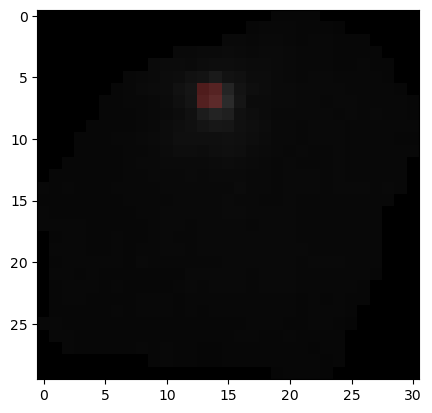

In [441]:
plt.imshow(df.iloc[161,8])